## Imports

In [1]:
%%capture
!pip install seaborn
!pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics

## Read Data

In [3]:
df_clinical = pd.read_csv("./train_clinical_data.csv")
df_peptides = pd.read_csv("./train_peptides.csv")
df_proteins = pd.read_csv("./train_proteins.csv")

## Data Summary

In [4]:
df_clinical.head(10)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [5]:
df_proteins.head(10)

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.30
1,55_0,0,55,O00533,732430.00
2,55_0,0,55,O00584,39585.80
3,55_0,0,55,O14498,41526.90
4,55_0,0,55,O14773,31238.00
5,55_0,0,55,O14791,4202.71
6,55_0,0,55,O15240,177775.00
7,55_0,0,55,O15394,62898.20
8,55_0,0,55,O43505,333376.00
9,55_0,0,55,O60888,166850.00


In [6]:
df_peptides.head(10)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7
5,55_0,0,55,O00533,TLKIENVSYQDKGNYR,23216.5
6,55_0,0,55,O00533,VIAVNEVGR,170878.0
7,55_0,0,55,O00533,VMTPAVYAPYDVK,148771.0
8,55_0,0,55,O00533,VNGSPVDNHPFAGDVVFPR,55202.1
9,55_0,0,55,O00584,ELDLNSVLLK,27229.3


## Target Preparation

In [7]:
patients = {}
df_clinical[f'updrs_3_next_year'] = 0

for patient_id in df_clinical.patient_id.unique():
    patient = df_clinical[df_clinical.patient_id == patient_id]
    for month in patient.visit_month.values:
        future_score = patient[patient.visit_month == month + 12][f'updrs_3'].to_list() 
        if (future_score == []): future_score = np.NaN
        patient.loc[patient.visit_month == (month), ['updrs_3_next_year']] = future_score
    patients[patient_id] = patient

In [8]:
clinical_features = pd.concat(patients.values(), ignore_index=True).set_index('visit_id').iloc[:,7:]
clinical_features.dropna(inplace=True)
clinical_features.head(10)

,updrs_3_next_year
visit_id,
55_0,41.0
55_6,38.0
55_12,49.0
55_18,49.0
55_24,51.0
55_30,41.0
55_36,52.0
55_42,51.0
55_48,56.0


## Feature Preparation

#### Proteins

In [9]:
protein_features = df_proteins.pivot(index='visit_id', columns='UniProt', values='NPX')
protein_features.head()

UniProt,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,129048.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,108114.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,163776.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,56725.0,...,557904.0,44556.90,155619.0,14647.9,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,85767.1,...,NaN,47836.70,177619.0,17061.1,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55


#### Peptides

In [10]:
peptide_features = df_peptides.pivot(index='visit_id', columns='Peptide', values='PeptideAbundance')
peptide_features.head()

Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,6580710.0,31204.4,7735070.0,NaN,NaN,NaN,46620.3,236144.0,NaN,NaN,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
10053_12,6333510.0,52277.6,5394390.0,NaN,NaN,NaN,57554.5,108298.0,45885.4,NaN,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,7129640.0,61522.0,7011920.0,35984.7,17188.0,19787.3,36029.4,708729.0,5067790.0,30838.2,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,7404780.0,46107.2,10610900.0,NaN,20910.2,66662.3,55253.9,79575.5,6201210.0,26720.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,13788300.0,56910.3,6906160.0,13785.5,11004.2,63672.7,36819.8,34160.9,2117430.0,15645.2,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [11]:
print(f'protein: {protein_features.shape}')
print(f'peptide: {peptide_features.shape}')

protein: (1113, 227)
peptide: (1113, 968)


#### Combining Features

In [12]:
df = clinical_features \
    .merge(protein_features, left_index=True, right_index=True, how='left') \
    .merge(peptide_features, left_index=True, right_index=True, how='left')
df['visit_month'] = df.reset_index().visit_id.str.split('_').apply(lambda x: int(x[1])).values
df.head()

,updrs_3_next_year,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_month
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,41.0,11254.3,732430.0,39585.8,41526.9,31238.0,4202.71,177775.0,62898.2,333376.0,...,16492.3,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4,0
55_6,38.0,13163.6,630465.0,35220.8,41295.0,26219.9,4416.42,165638.0,62567.5,277833.0,...,13198.8,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9,6
55_12,49.0,15257.6,815083.0,41650.9,39763.3,30703.6,4343.60,151073.0,66963.1,332401.0,...,17873.8,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1,12
55_18,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
55_24,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24


In [13]:
visit_month_list = df.reset_index().visit_id.str.split('_').apply(lambda x: int(x[1])).unique().tolist()
protein_list = protein_features.columns.to_list()
peptide_list = peptide_features.columns.to_list()

In [14]:
X = df[protein_list + ["visit_month"]]
y = df[clinical_features.columns]
print(f'X and y shape: {X.shape, y.shape}')

X and y shape: ((1858, 228), (1858, 1))


#### Imports

In [15]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression

In [25]:
X.visit_month = X.visit_month.astype('float')
y = y.astype('float')

feature_transformer = ColumnTransformer([
    (
        'numerical',
        make_pipeline(IterativeImputer(), StandardScaler(), SelectKBest(score_func=f_regression, k=50)),
        make_column_selector(dtype_include='number')
    ),
])

X_transformed = feature_transformer.fit_transform(X, y.values.ravel())

<ipython-input-25-7fa37c83aba3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.visit_month = X.visit_month.astype('float')


In [17]:
print(f'X, X_transformed, and y shapes: {X.shape, X_transformed.shape, y.shape}')

X, X_transformed, and y shapes: ((1858, 228), (1858, 10), (1858, 1))


### sMAPE Function

In [18]:
import tensorflow.keras.backend as K

In [19]:
def smape_loss(y_true, y_pred):
    epsilon = 0.1
    numer = K.abs(y_pred - y_true)
    denom = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = numer / (denom/2)
    smape = tf.where(tf.math.is_nan(smape), tf.zeros_like(smape), smape)
    return smape

### TensorFlow Model

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L2
from keras.utils.vis_utils import plot_model

In [26]:
input_shape = [X_transformed.shape[1]]

model = tf.keras.Sequential()
model.add(Dense(128, input_shape=input_shape, activation='relu', kernel_regularizer=L2(0.01)))
model.add(Dropout(0.8))
model.add(Dense(64, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1]))
model.summary()

model.compile(optimizer='adam', loss = smape_loss)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               6528      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

<Axes: >

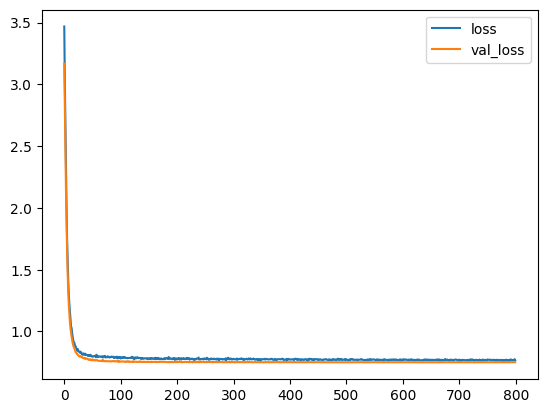

In [27]:
history = model.fit(
    X_transformed,
    y,
    epochs = 800,
    verbose = False,
    validation_split = .2
)

pd.DataFrame(history.history).plot()

In [24]:
print("best validation loss:", min(history.history['val_loss']))

best validation loss: 0.7495756149291992
